In [1]:
# Robustness test of stereotypy cutoffs

In [2]:
!date
!pwd

Wed Jun 22 14:28:05 PDT 2022
/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosis


In [3]:
import os
import sys
import pickle
import datetime
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from matplotlib.colors import ListedColormap
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
config = general.load_config_file(path_config)
control = controller.Controller(config)
device = io.LocalStagingIO(control)
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosis/../tools/common.py'>

In [6]:
table = common.CorrTable(control)
# table.filters = {"Corr": ("gt",0.027), "Delta": ("gt",0.035), "Swap": ("lt",0.05), "ABSpct": ("gt", 0.2), "Pct": ("gt", 0.2)}

In [7]:
table.apply_filters(metrics=["Corr","Delta"], replace_with_nan=False)
comp_cols = [f for f in table.comparisons.keys()]
table.cluster(cols=comp_cols, thresh=0.05, show=False)
df, columns = table.get_df(group=None, remove_symm=False, return_col_names=True)
# Find names of columns we want to set style for
# Assumes columns are ordered in the same way for
# all combinations
comp_cols, corr_cols, delta_cols, swap_cols = columns

### Concordance

In [8]:
# Creating the color coded table for figure mitotic
mxs, sws = [], []
for comp_col, swap_col in zip(comp_cols, swap_cols):
    mx = df.set_index(["S1","S2"], drop=True)[comp_col].unstack(level="S2")
    sw = df.set_index(["S1","S2"], drop=True)[swap_col].unstack(level="S2")
    mxs.append(mx.values)
    sws.append(sw.values)
mxs = np.array(mxs)
sws = np.array(sws)

In [45]:
importlib.reload(common)
masker = common.Masker(control)
masker.set_data(mxs, sws)
masker.execute()
df1, df2, cmap = masker.get_result_as_dataframes_and_cmap(ignore_confidence=True)

In [47]:
[int(255*c) for c in cmap[2]]

[100, 149, 237]

In [10]:
for c in df2.columns:
    df2.loc[df1[c].isin([5,6,7,8]), c] = 3
df1.at["AAVS1", "AAVS1"] = 1

'AVG_CORR_OF_REPS-STR-ColorCodedMask-1'

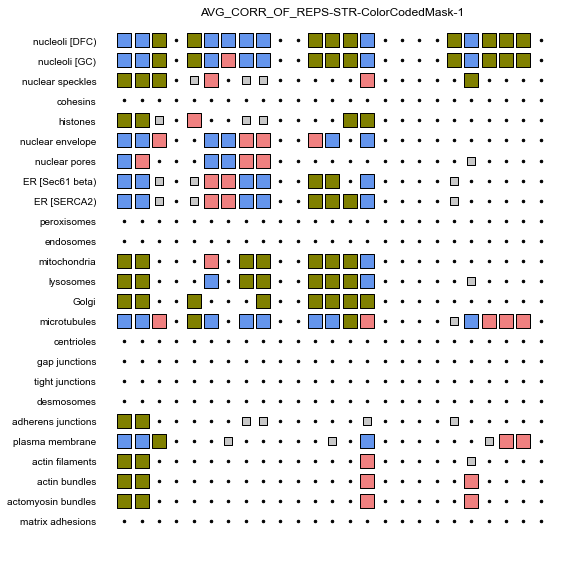

In [11]:
importlib.reload(plotting)
row = pd.Series({"shape_mode": "ColorCodedMask", "mpId": 1, "aggtype": "AVG_CORR_OF_REPS", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(df1, df2, colors=cmap, size_scale=25, display=True, hide_colors=[1])

In [12]:
res = []
mx = df1.values
for j in range(mx.shape[0]):
    for i in range(j+1, mx.shape[1]):
        si = mx[i,i]
        sj = mx[j,j]
        cij = mx[j,i]
        if cij in [2,3,4]:
            res.append({"Si": si, "Sj": sj, "Cij": cij, "genes": f"{df1.index[i]}-{df1.index[j]}"})
res = pd.DataFrame(res)

In [13]:
genes = res.groupby(["Si", "Sj", "Cij"])["genes"].apply(lambda x: list(np.unique(x)))

In [14]:
res = pd.DataFrame(res.groupby(["Si", "Sj", "Cij"]).size(), columns=["npairs"])
res = res.reset_index()

In [15]:
def get_color(v):
    return '%02x%02x%02x' % tuple([int(255*c) for c in cmap[v]])
def get_bin_color(v, val):
    if v == val:
        print(v)
        return "#000000"
    return "#FFFFFF"
def match_vals(vals, sets):
    for v, st in zip(vals, sets):
        if st == "any":
            continue
        if v not in st:
            return False
    return True

def add_flag_column(df, flags, name, default):
    df[name] = default
    for index, row in df.iterrows():
        for sets in flags:
            match = match_vals([row[c] for c in ["Si","Sj","Cij"]], sets)
            if match:
                df.at[index, name] = not default
                break
    return df

In [16]:
flag_a = [([4],[4],[3]), ([3],[3],[4]), ([1],[1],[1,2,3,4])]
res = add_flag_column(df=res, flags=flag_a, name="a", default=True)
flag_nb = [([2,4],"any",[3]), ("any",[2,4],[3]), ([1],[1],[4]), ([3],[3],[2,4])]
res = add_flag_column(df=res, flags=flag_nb, name="b", default=True)
flag_c = [([1],[4],[2]), ([4],[1],[2]), ([4],[2],[3]), ([2],[4],[3]), ([4],[4],[3]), ([3],[3],[4])]
res = add_flag_column(df=res, flags=flag_c, name="c", default=False)

In [17]:
res["pairs"] = genes.values

In [18]:
res.style.set_properties(
    **{'color': 'black !important',
       'border': '1px gray solid !important'}
).set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px gray solid !important')]}]
).applymap(
    lambda v: f"background-color: #{get_color(v)}", subset=["Si", "Sj", "Cij"]
).background_gradient(
    cmap="binary", subset=["a", "b", "c"], vmin=0, vmax=1
)

,Si,Sj,Cij,npairs,a,b,c,pairs
0,1,1,4,2,False,False,False,"['ACTN1-AAVS1', 'MYH10-AAVS1']"
1,1,2,2,2,True,True,False,"['AAVS1-FBL', 'AAVS1-NPM1']"
2,1,2,3,6,True,False,False,"['ACTB-FBL', 'ACTB-NPM1', 'ACTN1-FBL', 'ACTN1-NPM1', 'MYH10-FBL', 'MYH10-NPM1']"
3,1,3,3,1,True,True,False,['AAVS1-SON']
4,1,4,2,1,True,True,True,['AAVS1-TUBA1B']
5,1,4,4,3,True,True,False,"['ACTB-TUBA1B', 'ACTN1-TUBA1B', 'MYH10-TUBA1B']"
6,2,2,2,10,True,True,False,"['ATP2A2-FBL', 'ATP2A2-NPM1', 'ATP2A2-SEC61B', 'LMNB1-FBL', 'LMNB1-NPM1', 'NPM1-FBL', 'NUP153-FBL', 'NUP153-LMNB1', 'SEC61B-FBL', 'SEC61B-NPM1']"
7,2,2,4,5,True,True,False,"['ATP2A2-LMNB1', 'ATP2A2-NUP153', 'NUP153-NPM1', 'SEC61B-LMNB1', 'SEC61B-NUP153']"
8,2,3,4,1,True,True,False,['LMNB1-SON']
9,3,2,2,1,True,True,False,['LAMP1-LMNB1']


In [19]:
print("(change concordance) = ", (res.npairs).sum())
print("(a) = ", (res.a.values*res.npairs).sum())
print("(b) = ", (res.b.values*res.npairs).sum())
print("(c) = ", (res.c.values*res.npairs).sum())

(change concordance) =  64
(a) =  61
(b) =  36
(c) =  4


In [20]:
df_cat = pd.DataFrame(np.ones_like(df1.values), columns=df1.columns, index=df1.index)

In [34]:
for index, row in res.iterrows():
    for pair in row.pairs:
        gene1, gene2 = pair.split("-")
        df_cat.at[gene1, gene2] = df_cat.at[gene2, gene1] = 2 if row.b else 3
        if row.c:
            if row.b:
                df_cat.at[gene1, gene2] = df_cat.at[gene2, gene1] = 4
            else:
                df_cat.at[gene1, gene2] = df_cat.at[gene2, gene1] = 5

In [41]:
cmap = {1: (1,1,1), 2: (0,0,0), 3: (1,1,1), 4: (0,0,0), 5: (1,1,1)}
markers = {1: None, 2: "$\star$", 3: "$\star$", 4: "$\star$", 5: "$\star$"}

'AVG_CORR_OF_REPS-STR-ColorCodedCategories-1'

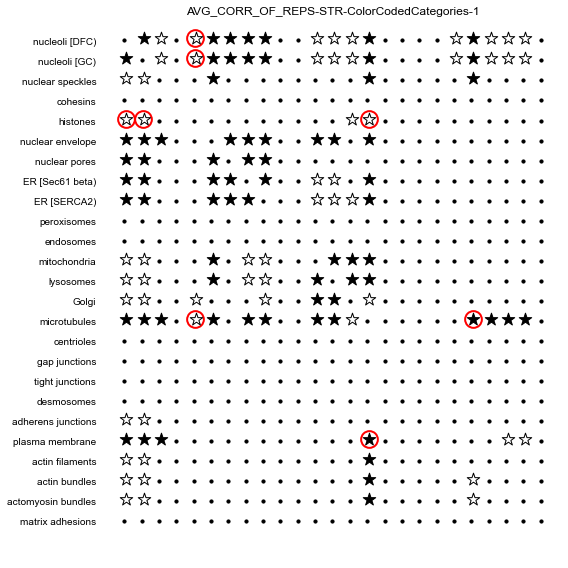

In [44]:
importlib.reload(plotting)
row = pd.Series({"shape_mode": "ColorCodedCategories", "mpId": 1, "aggtype": "AVG_CORR_OF_REPS", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(df_cat, df2, colors=cmap, size_scale=40, display=True, hide_colors=[1], markers=markers, highlight=[4,5])